This code has been influenced by several resources:
     1. Understanding Molecular Simulations: Understanding Molecular Simulations
         http://www.cchem.berkeley.edu/chem195/index.html 
     2. Principles of modern molecular simulation methods, S12
         https://engineering.ucsb.edu/~shell/che210d/assignments.html
     3. Code based on R. LeSars Computational Materials Science textbook. Original Author: Stefan Bringuier, Affiliation:
         University of Arizona, Department: Materials Science and Engineering, Date: August 13, 2013
     4. Molecular Simulations, S13 http://www.pages.drexel.edu/~cfa22/msim/msim.html
     5. Computer Simulation of Organic and Biological Molecules
         http://research.chem.psu.edu/shsgroup/chem647/newNotes/newNotes.html
     6. Interactive Molecular Dynamics https://physics.weber.edu/schroeder/md/InteractiveMD.pdf
     7. Coarse Graining and Mesoscopic Simulations by Hector Pollman http://slideplayer.com/slide/3447771/
     8. For Ewald Summations:
         http://www.grs-sim.de/cms/upload/Carloni/Tutorials/CMB/ComputerSimulationMethods_2.pdf
         http://www.ukm.my/jkukm/wp-content/uploads/2016/03/21-39.pdf 
         http://www.pages.drexel.edu/~cfa22/msim/node48.html 
         https://www.icp.uni-stuttgart.de/~icp/mediawiki/images/e/eb/T8w.pdf 
            By: Joan J. Cerdà (jcerda in the fias.uni-frankfurt.de)
            Title: 8: Long range interactions: Direct sum and Ewald summation.
            June 21, 2007 SimBio group, FIAS, Frankfurt
         https://github.com/chemlab/chemlab/blob/180287718380ae635aa6401cbd183d93e3bdc81c/chemlab/md/ewald.py
         Equations used - http://ydsumith.weebly.com/equations-706485.html
     9. Langevin Dynamics:
         doi:10.1016/j.cplett.2006.07.086 &
         http://itf.fys.kuleuven.be/~enrico/Teaching/molecular_dynamics_2015.pdf E. Carlon, M. Laleman and S. Nomidis – 
             Academic year 2015/2016, Computational Physics: Molecular Dynamics Simulations
    10. Dissapative Particles Dynamics (DPD): paper by Dr. Schiller **need to find this reference!**
        https://pdfs.semanticscholar.org/7f5b/c41af48b4b436a5f9a01720fadc477480e08.pdf

In [112]:
import numpy as np
import math
import scipy as sp
from scipy import special
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [113]:
def print_xyz(natoms,t,p):
    """Print a XYZ file for the specified move"""
    filename = "output%000006d.xyz" % t

    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    FILE.write('Timestep: %f \n' % t)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (p[i,0],p[i,1],p[i,2]))
    FILE.close()

In [114]:
def PrintVelocity(natoms,t,v):
    """Print a txt file for the specified move"""
    filename = 'velocity%000006d.txt' % t
    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    FILE.write('Timestep: %f \n' % t)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (v[i,0],v[i,1],v[i,2]))
    FILE.close()

In [115]:
def PrintForces(natoms,t,f):
    """Print a txt file for the specified move"""
    filename = "forces%000006d.txt" % t
    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    FILE.write('Timestep: %f \n' % t)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (f[i][0],f[i][1],f[i][2]))
    FILE.close()

In [116]:
def PrintForcesDPD(natoms,t,f):   
    """Print a txt file for the specified move"""
    filename = "forces%000006d.txt" % t
    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    FILE.write('Timestep: %f \n' % t)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (f[i][0],f[i][1],f[i][2]))
    FILE.close()

In [117]:
def FCC(natoms,L):
    ''' Initial positions
    input:
    natoms - number of atoms
    L - length
    output:
    px,py,pz - position coordinates
    '''
    part = np.zeros((natoms,3),float)
    
    for i in range(natoms):
        p = np.random.rand(3)*L
        for j in range(0,i):
            dist = np.sqrt((p[0]-part[j,0])**2. + (p[1]-part[j,1])**2. + (p[2]-part[j,2])**2.)
            while dist < 1.95:
                p = np.random.rand(3)*L
                dist = np.sqrt((p[0]-part[j,0])**2. + (p[1]-part[j,1])**2. + (p[2]-part[j,2])**2.)
        part[i] = np.array([p],float)
    
    px = part[:,0]
    py = part[:,1]
    pz = part[:,2]

    # Plot in 2D
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    xs = px
    ys = py
    ax.scatter(xs,ys,c='b',marker='o')
    ax.set_xlabel('X Coord')
    ax.set_ylabel('Y Coord')
    plt.title(r"Initial 2D Positions") #title of the plot
    plt.savefig('2D_positions.png', format='png')
    
    # Plot in 3D
    fig2 = plt.figure()
    ax=fig2.add_subplot(111,projection='3d')
    xs=px
    ys=py
    zs=pz
    ax.scatter(xs,ys,zs,c='b',marker='o')
    ax.set_xlabel('X Coord')
    ax.set_ylabel('Y Coord')
    ax.set_zlabel('Z Coord')
    plt.title(r"Initial 3D Positions") #title of the plot
    plt.savefig('3D_positions.png', format='png')
    
    """Print a XYZ file for the specified move"""
    filename = 'initialpositions.txt'
    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (part[i,0],part[i,1],part[i,2]))
    FILE.close()
                   
    return part

In [118]:
def MBdist(natoms,temp,kbn,massn):
    '''Use Maxwell-Boltzmann distribution to describe how molecules are moving
    between velocities v & v+dv. This code utilizes the Box-Muller method.
    input:
    natoms - number atoms
    temp - temperature
    kbn - boltzmann constant in natural units
    massn - mass in natural units
    ouput:
    vel - velocity distribution array natoms x dim
    '''
    # Defining variables for this function
    dim = 3
    
    # Initial velocity
    # Creating a natoms_row x dim_column zero matrix 
    vel = np.zeros((natoms,dim))
    
    # Creating a dim_row x 1 momentum vector (3x1)
    momentum = np.zeros((dim,1)) 
    
    # Choose a range of velocities randomly, using the Box-Muller Method.
    for i in range(dim):
        v = np.random.rand(natoms)
        veldist = np.sqrt(-2.*np.log10(v))*np.cos(2.*np.pi*v)
        # Multiply by np.sqrt(k*T/mass) to get proper distribution of 
        # velocities. units m/s
        vel[:,i] = np.sqrt(kbn*temp/massn)*veldist 
        # Units of kg/mol*m/s 
        momentum[i] = massn*np.sum(vel[:,i])
    
    # Momentum per atom, units m/s
    ppa = momentum/(natoms*massn)
    # Initial kinetic energy
    KE = 0.0
    
    for i in range(dim):
        # Correct so there is no overall momentum, units m/s
        vel[:,i] -= ppa[i]
        # KE = KE + np.sum(np.square(vel[:,i])) np.square: x*x, of the same 
        #shape and dtype as x. Returns scalar if x is a scalar. Units (m/s)**2
        KE += np.sum(np.square(vel[:,i]))
    
    KE *= 0.5
    # If T is specified, scale velocities
    KE_T = (3.0/2.0)*(natoms*temp)
    rescale = np.sqrt(KE_T/KE)
    vel *= rescale
    
    """Print a txt file for the specified move"""
    filename = 'initialvelocity.txt'
    FILE = open(filename, 'w')
    FILE.write('%d \n' % natoms)
    for i in range(natoms):
        FILE.write('Ar %8.3f %8.3f %8.3f \n' % (vel[i,0],vel[i,1],vel[i,2]))
    FILE.close()

    return vel

In [119]:
def PBC1(pos,length):
    '''Subroutine to apply periodic boundary conditions when updating positions
    input:
    x - position
    L - length of a unit cell
    output:
    x - position PBC corrected
    '''
    for i in range(len(pos)):
        for j in range(0,3):
            while (pos[i,j] < 0.0):
                pos[i,j] += length
            while (pos[i,j] > length):
                pos[i,j] -= length
            else:
                break
    return pos

In [120]:
def PBC2(x,length):
    '''Subroutine to apply periodic boundary conditions 
    input:
    x - position
    L - length of a unit cell
    output:
    x - position PBC corrected
    '''
    hL = 0.5*length
    
    if x < -hL:
        x += length
    elif x > hL:
        x -= length
    
    return x

In [121]:
def LJ_Potential(natoms,rc,p):
    ''' Calculate the LJ potential
    input:
    natoms - number of atoms
    rc - rcutoff in natural units
    neighbors - generated neighbors list
    px,py,pz - positions
    ouput:
    vir - virial term
    PEc - corrected potential energy taking into account the vertical &
          force shift
    '''    
    vir = 0.0
    PE = 0.0
    PEc = 0.0

    # Setting up the variables for the distance formula.
    for i in range(natoms):
        for j in range(0, i):
            dx = p[i,0] - p[j,0]
            dy = p[i,1] - p[j,1]
            dz = p[i,2] - p[j,2]
            
            # Apply PBC2
            X = PBC2(dx,length)
            Y = PBC2(dy,length)
            Z = PBC2(dz,length)
            
            # Distance & distance squared for r (also called rij) & rc
            r = np.sqrt(X**2. + Y**2. + Z**2.) 
            r2 = X**2. + Y**2. + Z**2.
            rc2 = rc*rc
        
            # Only interested in atoms whose distances is less than rc 
            if r < rc:
                # U(r) = 4*epsilon(sigma/rij)**12 - (sigma/rij)**6
                # Use LJ units: assume sigma = 1 & epsilon = 1
                r6i = 1.0/(r2*r2*r2)
                rc6i = 1.0/(rc2*rc2*rc2)

                # Non-corrected potential energy
                PEr = r6i*r6i - r6i
                PErc = rc6i*rc6i - rc6i
                
                # Potential shift
                PEs = PE + PEr - PErc 
                
                # Force shift correction, unitless
                # PEfs = PE + (r6i*r6i - r6i) - (rc6i*rc6i - rc6i) - (r-rc)*(12/rc)*(rc6i*rc6i - 0.5*rc6i)
                
                # F = -(48*epsilon/rij)*((sigma/rij)**12 - 0.5*(sigma/rij)**6)*rhat
                F = (r6i*r6i - 0.5*r6i)/r2
                
                #Virial term
                vir += F
                
                # Potential with the shift correction
                PEc += PEs
                
                # Potential with the force shift correction
                #PEc += PEfs

    vir *= 48.
    #PE *= 4.
    PEc *= 4.
    
    return vir,PEc

In [122]:
def LJ_Force(natoms,ts,rc,p): 
    ''' Calculate the LJ forces
    input:
    natoms - number of atoms
    ts - time step
    rcut - the cutoff radius
    neighbors - the generated neighborlist
    p - positions
    ouput:
    forces - F(r) = -dU(r)/dr
    '''
    forces = np.zeros((natoms,3))
    # Setting up the variables for the distance formula.
    for i in range(natoms):
        Fx = 0.0
        Fy = 0.0
        Fz = 0.0
        for j in range(0,i):
            X = p[i,0] - p[j,0]
            Y = p[i,1] - p[j,1]
            Z = p[i,2] - p[j,2]
            
            # Apply PBC2
            X = PBC2(X,length)
            Y = PBC2(Y,length)
            Z = PBC2(Z,length)

            # Distance squared for r (also called rij)
            r = np.sqrt(X**2.0 + Y**2.0 + Z**2.0) 

            if r < rc:
                # assume sigma = 1 & epsilon = 1
                # Fx = 6x*(2/r**14 - 1/r**8),Fy = 6y*(2/r**14 - 1/r**8),Fz = 6z*(2/r**14 - 1/r**8)
                Fx += 6.0*X*(2.0/r**14.0 - 1.0/r**8.0)
                Fy += 6.0*Y*(2.0/r**14.0 - 1.0/r**8.0)
                Fz += 6.0*Z*(2.0/r**14.0 - 1.0/r**8.0)
                
        forces[i]=[Fx,Fy,Fz]
    
    #print(forces)
    #print(len(forces))
    #print(forces.shape)
    return forces

In [123]:
def LangevinForce(natoms,v,f):
    '''
    input:
    v - velocities
    f - LJ forces (one big array (a1,a2,etc.) where a1 = [x1,y1,z1], a2 = [x2,y2,z2], etc.)
    output:
    force - forces from Langevin Dynamics
    '''
    LangF = np.zeros((natoms,3))
    for i in range(natoms):
        LangFx = 0.0
        LangFy = 0.0
        LangFz = 0.0
        # Langevin_f(n) += f(n) - gamma*mass*v(n) + sigmaLang*eta
        LangFx += f[i][0] - gamma*v[i,0] + sigmaLangForce*eta
        LangFy += f[i][1] - gamma*v[i,1] + sigmaLangForce*eta
        LangFz += f[i][2] - gamma*v[i,2] + sigmaLangForce*eta
        
        LangF[i]=[LangFx,LangFy,LangFz]
    #print(LangF)
    return LangF

In [124]:
def LangVeloVerlet(natoms,ts,r,v,f):
    ''' Velocity Verlet Integration of equations of motion
    input:
    natoms - number of atoms
    ts - timestep
    p - positions
    v - velocities
    f - forces
    output
    updated poss,vel,forces
    '''
    for i in range(natoms):       
        # Partial update of the velocities
        v[i,0] += 0.5*ts*f[i][0]
        v[i,1] += 0.5*ts*f[i][1]
        v[i,2] += 0.5*ts*f[i][2]

        # First integration half-step
        # Update positions
        r[i,0] += ts*v[i,0]
        r[i,1] += ts*v[i,1]
        r[i,2] += ts*v[i,2]
        #print(r)

        # Apply PBC1
        r = PBC1(r,length)

        # Calculate forces
        newf = LJ_Force(natoms,ts,rcut,r)
        Langforce = LangevinForce(natoms,v,newf)

        # Second integration half-step
        v[i,0] += 0.5*ts*Langforce[i][0]
        v[i,1] += 0.5*ts*Langforce[i][1]
        v[i,2] += 0.5*ts*Langforce[i][2]

        KE = 0.5*np.sum(np.square(v),dtype=np.float64)
    #print(KE)
               
    return r,Langforce,v,KE

In [125]:
def DPDForce1(natoms,p,v,f):
    ''' Dissipative Particle Dynamics: momentum conserving thermostat
    input:
    rc - rcutoff
    p - positions
    v - velocities
    f - LJ force (aka conservative force)
    output
    DPD force
    '''
    forces = []
    
    # Setting up the variables for the distance formula.
    for i in range(natoms):
        fx = 0.0
        fy = 0.0
        fz = 0.0
        Fx = 0.0
        Fy = 0.0
        Fz = 0.0
        fdx = 0.0
        fdy = 0.0
        fdz = 0.0
        frx = 0.0
        fry = 0.0
        frz = 0.0
        
        # Consevative force is the LJ force. If it's equal to zero, it's called the "ideal DPD fluid"
        fx += f[i][0]
        fy += f[i][1]
        fz += f[i][2]
        #print(fx,fy,fz)
        
        for j in range(0,i):
            X = p[i,0] - p[j,0]
            Y = p[i,1] - p[j,1]
            Z = p[i,2] - p[j,2]
            
            # Apply PBC2
            X = PBC2(X,length)
            Y = PBC2(Y,length)
            Z = PBC2(Z,length)
            
            r = np.sqrt(X**2. + Y**2. + Z**2.)
            
            xhat = X/r
            yhat = Y/r
            zhat = Z/r
            
            VX = v[i,0] - v[j,0]
            VY = v[i,1] - v[j,1]
            VZ = v[i,2] - v[j,2]
            
            if r < rcutdpd:

                rdrc = r/rcutdpd
                
                omegaD = 2.0*(1.0 - rdrc)
                omegaR = np.sqrt(2.0*(1.0 - rdrc))
                
                # Dissipative force
                fdx += -gamma*omegaD*(xhat*VX)*xhat
                fdy += -gamma*omegaD*(yhat*VY)*yhat
                fdz += -gamma*omegaD*(zhat*VZ)*zhat
                #print(fdx,fdy,fdz)
                
                # Random force
                frx += sigmaR*omegaR*xhat*eta
                fry += sigmaR*omegaR*yhat*eta
                frz += sigmaR*omegaR*zhat*eta
                #print(frx,fry,frz)
        
        Fx += fx + fdx + frx
        Fy += fy + fdy + fry
        Fz += fz + fdz + frz
        
        forces.append([Fx,Fy,Fz])
    return forces

In [126]:
def DPDVeloVerlet(natoms,ts,r,v,f):
    ''' Velocity Verlet Integration of equations of motion
    input:
    natoms - number of atoms
    ts - timestep
    p - positions
    v - velocities
    f - forces from DPDForce1 (have LJ conservative forces + dissipative + random)
    output
    updated poss,vel,forces
    '''
    # Setting up the variables for the distance formula.
    for i in range(natoms):  
        # Partial update of the velocities
        v[i,0] += 0.5*ts*f[i][0]
        v[i,1] += 0.5*ts*f[i][1]
        v[i,2] += 0.5*ts*f[i][2]

        # First integration half-step
        # Update positions
        r[i,0] += ts*v[i,0]
        r[i,1] += ts*v[i,1]
        r[i,2] += ts*v[i,2]

        # Apply PBC1
        r = PBC1(r,length)

        # Calculate forces
        newf = LJ_Force(natoms,ts,rcut,r)
        forces = DPDForce1(natoms,r,v,newf)

        # Second integration half-step
        v[i,0] += 0.5*ts*forces[i][0]
        v[i,1] += 0.5*ts*forces[i][1]
        v[i,2] += 0.5*ts*forces[i][2]

        KE = 0.5*np.sum(np.square(v),dtype=np.float64)
               
    return r,forces,v,KE

In [127]:
def DPDForce2(natoms,p,v):
    ''' USE THIS ONLY IF YOU'RE RUNNING THE 2ND ORDER INTEGRATOR
    Dissipative Particle Dynamics: momentum conserving thermostat
    input:
    rc - rcutoff
    p - positions
    v - velocities
    f - LJ force (aka conservative force)
    output
    DPD force
    '''
    # Setting up the variables for the distance formula.
    for i in range(natoms):
        fdx = 0.0
        fdy = 0.0
        fdz = 0.0
        frx = 0.0
        fry = 0.0
        frz = 0.0
        for j in range(0, i):
            X = p[i,0] - p[j,0]
            Y = p[i,1] - p[j,1]
            Z = p[i,2] - p[j,2]
            
            # Apply PBC2
            X = PBC2(X,length)
            Y = PBC2(Y,length)
            Z = PBC2(Z,length)
            
            r = np.sqrt(X**2. + Y**2. + Z**2.)
            
            xhat = X/r
            yhat = Y/r
            zhat = Z/r
            
            VX = v[i,0] - v[j,0]
            VY = v[i,1] - v[j,1]
            VZ = v[i,2] - v[j,2]
            
            if r < rcutdpd:

                rdrc = r/rcutdpd
                
                omegaD = 2.0*(1.0 - rdrc)
                omegaR = np.sqrt(2.0*(1.0 - rdrc))
                
                # Consevative force is the LJ force. If it's equal to zero, it's called the "ideal DPD fluid"
                # Dissipative force
                fdx += -gamma*omegaD*(xhat*VX)*xhat
                fdy += -gamma*omegaD*(yhat*VY)*yhat
                fdz += -gamma*omegaD*(zhat*VZ)*zhat
                # Random force
                frx += sigmaR*omegaR*xhat*np.random.normal()
                fry += sigmaR*omegaR*yhat*np.random.normal()
                frz += sigmaR*omegaR*zhat*np.random.normal()
                
    return fdx,fdy,fdz,frx,fry,frz

In [128]:
def ModDPDVeloVerlet(natoms,ts,r,v,fdx,fdy,fdz,frx,fry,frz):
    ''' NEEDS TO BE FIXED IF I WANT TO USE IT!!!
    Modified Velocity Verlet Integration of equations of motion for DPD: 2nd order integrator
    input:
    natoms - number of atoms
    ts - timestep
    r - positions
    v - velocities
    fx,fy,fz - LJ forces (aka conservative forces)
    output
    updated poss,vel,forces
    '''
    forces = []
    
    f = LJ_Force(natoms,ts,rcut,r)
    for a in range(natoms):
        fx = f[a][0]
        fy = f[a][1]
        fz = f[a][2]
    
    # Setting up the variables for the distance formula.
    for i in range(natoms):
        # First integration half-step
        # Partial update of the velocities
        v[i,0] += 0.5*ts*(f[i][0] + fdx[i]) + 0.5*sqrt_ts*frx[i]
        v[i,1] += 0.5*ts*(f[i][1] + fdy[i]) + 0.5*sqrt_ts*fry[i]
        v[i,2] += 0.5*ts*(f[i][2] + fdz[i]) + 0.5*sqrt_ts*frz[i]
        
        v[i,0] += 0.5*ts*fdx[i] + 0.5*sqrt_ts*frx[i]
        v[i,1] += 0.5*ts*fdy[i] + 0.5*sqrt_ts*fry[i]
        v[i,2] += 0.5*ts*fdz[i] + 0.5*sqrt_ts*frz[i]

        # Update positions
        r[i,0] += v[i,0]*ts
        r[i,1] += v[i,1]*ts
        r[i,2] += v[i,2]*ts
        
        # Calculate forces
        fdx,fdy,fdz,frx,fry,frz = DPDForce2(natoms,r,v)
        forces.append([fx+fdx+frx,fy+fdy+fry,fz+fdz+frz])
        
        # Second integration half-step
        v[i,0] += 0.5*sqrt_ts*frx[i] + 0.5*ts*fdx[i]
        v[i,1] += 0.5*sqrt_ts*fry[i] + 0.5*ts*fdy[i]
        v[i,2] += 0.5*sqrt_ts*frz[i] + 0.5*ts*fdz[i]
    
        KE = 0.5*np.sum(np.square(v),dtype=np.float64)
          
    return r,forces,v,KE

In [129]:
def Update(t,natoms,density,vi,vol,PE,KE):
    '''
    input:
    natoms - number of atoms
    density - density
    t - timestep
    v - velocity array 
    vi - virial pressure term
    vol - volume
    PE - potential energy with the force shift
    KE - kinetic energy
    '''
    if t % 1 == 0:
        print ("Number of atoms: %i atoms" %(natoms))
        print("Box size = %sx%sx%s. Volume = %s A^3" % (boxsize[0],boxsize[1],boxsize[2],vol))
        print ("LJ units!")
        print ("Timestep    Energy[LJ]   Temperature[LJ]    Pressure[LJ]")
        print ("--------------------------------------------------------")
    
        #KE *= (1.0/2.0)
        T = (2./3.)*(KE/natoms)
        E = KE + PE      
        P = natoms*kbn*temp/vol + vi
        print ("%i       %2.f        %2.f        %2.f " %(t,E,T,P))

--------------------------------------------------------
Timestep size:  0
Number of atoms: 40 atoms
Box size = 9.0x9.0x9.0. Volume = 729 A^3
LJ units!
Timestep    Energy[LJ]   Temperature[LJ]    Pressure[LJ]
--------------------------------------------------------
0       37         1         3 
Number of atoms: 40 atoms
Box size = 9.0x9.0x9.0. Volume = 729 A^3
LJ units!
Timestep    Energy[LJ]   Temperature[LJ]    Pressure[LJ]
--------------------------------------------------------
1       5107742        85129         3 
Number of atoms: 40 atoms
Box size = 9.0x9.0x9.0. Volume = 729 A^3
LJ units!
Timestep    Energy[LJ]   Temperature[LJ]    Pressure[LJ]
--------------------------------------------------------
2       702883950498463616        11714732508307726         3 


KeyboardInterrupt: 

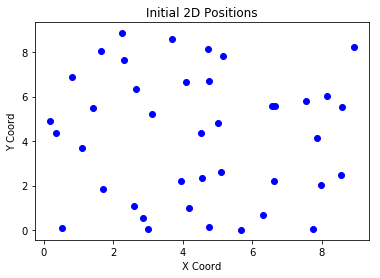

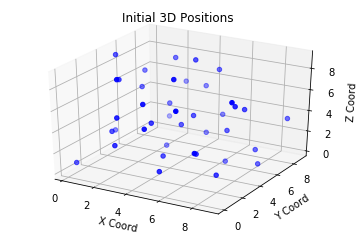

In [130]:
#Call the main function.
if __name__== "__main__":
    
    # User defined variables
    natoms = 40
    Thermostat = 'Langevin' # DPD or Langevin

    # Give the Lennard Jones parameters for the atoms
    # (these are the OPLS parameters for Krypton)
    sigma = 3.624         # angstroms
    epsilon = 0.317       # kcal mol-1
    mass = 83.798         # amu
    
    # Natural units
    en = 1.0
    sn = 1.0
    kbn = 1.0
    massn = 1.0
    #densityn = density/sigma**3
    tempn = 0.5
    rcutn = 3.0
    
    density = 0.316 
    temp = 0.728
    k_boltz = 1.987206504191549E-003  # kcal mol-1 K-1
    kb = 8.617343E-005
   
    # Runtime Parameters
    output = 1
    k = 10
    timestep = 0.001
    runtime = 1000
    
    # Cubic system
    vol = 729
    length = 9.0
    boxsize = [9.0, 9.0, 9.0]
    rcut = 2.6
    rverlet = rcut + 0.6*sigma
    neighborcut = rverlet + sigma
    
    # Size of the whole box
    Lx = length
    Ly = length
    Lz = length
    
    # Langevin & DPD Parameters
    # density = 3, sigma = 3, kbT = 1 (for water in DPD)
    # diffusion coeff = kb*T/mass*gamma
    ts2 = timestep*timestep
    sqrt_tscubed = np.sqrt(timestep**3)
    sqrt_three = np.sqrt(3.0)
    gamma = 1.0 #friction constant
    #sigmaLang = np.sqrt(2.0*kbn*temp*gamma/massn)
    sigmaLang = 3.0
    #sigmaLangForce = np.sqrt(2.0*gamma*massn*kbn*temp)
    sigmaLangForce = 1.4
    eta = np.random.normal()
    xi = np.random.normal()
    rho = 4.0
    rcutdpd = 3.0
    alphaDPD = 0.25 # repulsion parameter 
    sigmaR = 3.0 # np.sqrt(2*gamma*kbn*temp/massn) noise strength
    sqrt_ts = np.sqrt(timestep)
    lambdacoeff = 0.65
    
    # Ewald Summation Parameters:
    alphaEwald = 1.5 # this has to be optimized based on cutoff
    alphaEwaldsq = alphaEwald**2.
    kmax = 13.0
    kcut = 7.0
    
    # Initial Coordinates/Velocities
    positions = FCC(natoms,length)
    velocity = MBdist(natoms,temp,kbn,massn)
    
    # Lennard-Jones Potential & Virial term
    virial,potentialenergy = LJ_Potential(natoms,rcut,positions)
    
    if (Thermostat == 'Langevin'):
        # Initial Forces
        forces = LJ_Force(natoms,timestep,rcut,positions)

        # Use updated forces to calculate the Langevin force
        forces = LangevinForce(natoms,velocity,forces)
    
        # Time Loop
        print ("--------------------------------------------------------")
        print ("Timestep size: %2.f" %(timestep))
        
        t = 0
        while t <= runtime:
            
            # Calculate updated positions and velocitys
            positions,forces,velocity,kineticenergy = LangVeloVerlet(natoms,t,positions,velocity,forces)
            
            # Data Output
            if (t % output) == 0:
                Update(t,natoms,density,virial,vol,potentialenergy,kineticenergy)
                print_xyz(natoms,t,positions)
                PrintVelocity(natoms,t,velocity)
                PrintForces(natoms,t,forces)
            
            #print(t)
            t += 1
        
        print ("--------------------------------------------------------")
        print ("MD Run Complete ")
    
    elif (Thermostat == 'DPD'):
        # Initial Forces
        forces = LJ_Force(natoms,timestep,rcut,positions)
        
        # Initial Forces
        forces = DPDForce1(natoms,positions,velocity,forces)
        
        # Initial Forces
        #forcesdx,forcesdy,forcesdz,forcesrx,forcesry,forcesrz = DPDForce2(natoms,positions,velocity,forces)
        
        # Time Loop
        print ("--------------------------------------------------------")
        print ("Timestep size: %2.f" %(timestep))
        
        t = 0
        while t <= runtime:
            # Calculate the updated positions and velocities
            positions,forces,velocity,kineticenergy = DPDVeloVerlet(natoms,t,positions,velocity,forces)
            
            # Calculate the updated positions and velocities
            #positions,forces,velocity,kineticenergy = ModVeloVerlet(natoms,t,positions,velocity,forcesdx,forcesdy,forcesdz,forcesrx,forcesry,forcesrz)
            
            # Data Output
            if (t % output) == 0:
                Update(t,natoms,density,virial,vol,potentialenergy,kineticenergy)
                print_xyz(natoms,t,positions)
                PrintVelocity(natoms,t,velocity)
                PrintForcesDPD(natoms,t,forces)
            
            print(t)
            t += 1
        
        print ("--------------------------------------------------------")
        print ("MD Run Complete ")